Code for MohammadReza Safari's Thesis
Dataset: STEW
Analyze in 3classes

# Initializer

This code has been run on google colab.

In [ ]:
# 1. mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 2. set directory of data
%cd /content/gdrive/My Drive/Thesis/dDTF_images
base_dir='/content/gdrive/My Drive/Thesis/dDTF_images/3classes'

freq_band = 'theta'

# Define the checkpoint filepath for best model
model_checkpoint_filepath = base_dir + '/best_model_3classes_' + freq_band + '_Resnet50LSTM' + '.h5'
history_dir = base_dir + '/hist_Resnet50LSTM_3classes_SGD_' + freq_band


/content/gdrive/My Drive/Thesis/dDTF_images


In [ ]:
# 3. import libraries

import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer,Dense, Dropout, Input, Activation, TimeDistributed, Reshape
from tensorflow.keras.layers import  GRU, Bidirectional
from tensorflow.keras.layers import  Conv1D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, LSTM, ZeroPadding2D, GlobalAveragePooling2D, SpatialDropout2D, GlobalMaxPool1D,Convolution1D
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import math
import random
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from natsort import natsorted
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import cv2
import pickle
from PIL import Image

In [ ]:
# 4. define some methods

def smooth_curve(points, factor=0.2):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points


def plot_results(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  %matplotlib inline
  plt.plot(epochs, smooth_curve(acc), 'r', alpha = 0.6, label='Training acc')
  plt.plot(epochs, smooth_curve(val_acc), 'b', alpha = 0.6, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, smooth_curve(loss), 'r', alpha = 0.6, label='Training loss')
  plt.plot(epochs, smooth_curve(val_loss), 'b', alpha = 0.6, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

def plot_mean_of_all_folds(train_acc_list, val_acc_list, train_loss_list, val_loss_list):
  # Plot the mean of training and validation accuracy across all folds
  train_acc_mean = np.mean(train_acc_list, axis=0)
  val_acc_mean = np.mean(val_acc_list, axis=0)
  train_loss_mean = np.mean(train_loss_list, axis=0)
  val_loss_mean = np.mean(val_loss_list, axis=0)
  %matplotlib inline
  plt.plot(train_acc_mean, 'r', alpha = 0.6, label='Training Accuracy')
  plt.plot(val_acc_mean, 'b', alpha = 0.6, label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(train_loss_mean, 'r', alpha = 0.6, label='Training loss')
  plt.plot(val_loss_mean, 'b', alpha = 0.6, label='Validation loss')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

# def calculate_test_accuracy(model, X_test, Y_test):
#   fold_results = {}
#   Y_test = np_utils.to_categorical(Y_test)
#   predicted_probas = model.predict(np.array(X_test),steps = len(X_test))
#   fold_results['predicted_probas'] = predicted_probas
#   binary_prediction=[]
#   binary_prediction0=[]
#   for i in range(len(predicted_probas)):
#     #  binary_prediction0 = 1 if predicted_probas[i]>=0.5 else 0
#      binary_prediction0 = np.round(predicted_probas)
#      binary_prediction.append(binary_prediction0)
#   fold_results['binary_prediction'] = binary_prediction
#   conf_mat = confusion_matrix(binary_prediction, Y_test)
#   fold_results['confusion_matrix'] = conf_mat
#   acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
#   fold_results['test_accuracy'] = acc
#   print('Overall accuracy: {:.2f} %'.format(acc*100))
#   return fold_results

def test_accuracy(model, X_test, Y_test):
  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

  Y_test = np_utils.to_categorical(Y_test)
  Y_pred = model.predict(X_test)
  Y_pred = np.argmax(Y_pred, axis=1)
  Y_test = np.argmax(Y_test, axis=1)
  test_acc = accuracy_score(Y_pred,Y_test)
  cm = confusion_matrix(Y_test, Y_pred)
  plot_conf_mat(cm)

  return test_acc, cm


def plot_conf_mat(cm):
  # Normalize the confusion matrix
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  conf_labels = ['low', 'moderate', 'high']
  sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='.2%', xticklabels=conf_labels, yticklabels=conf_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

def get_model_metrics(cm):
  TP = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  TN = cm[1, 1]
  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)
  precision = TP / (TP + FP)
  FAR = FP / (FP + TN)
  FRR = FN / (FN + TP)
  print("Metrics:")
  print(f"Sensitivity: {sensitivity:.2f}")
  print(f"Specificity: {specificity:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"FAR: {FAR:.2f}")
  print(f"FRR: {FRR:.2f}")

  return sensitivity, specificity, precision, FAR, FRR


def create_model():
  conv_base = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
  # conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
  # conv_base = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

  conv_base.trainable = True

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(32)) #,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))

  cnn = models.Model(model.input, model.output)

  seq_input = Input(shape=(5,224,224,3))
  encoded_sequence = TimeDistributed(cnn)(seq_input)
  encoded_sequence = Bidirectional(LSTM(32, return_sequences=True))(encoded_sequence)

  #encoded_sequence = Dropout(rate=0.1)(encoded_sequence)
  encoded_sequence = Bidirectional(LSTM(32, return_sequences=False))(encoded_sequence)
  out = Dense(3, activation="softmax")(encoded_sequence)
  #out = Convolution1D(1, kernel_size=1, activation="sigmoid", padding="same")(encoded_sequence)

  cnn_lstm = models.Model(seq_input, out)
  cnn_lstm.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4),metrics=['acc'])

  if fold_count == 1:
    cnn_lstm.summary()
  return cnn_lstm


# Prepare Data

In [ ]:
# 5. load images data from drive

# hi_dir = base_dir + '/' + freq_band + '/hi'
# hi_data = os.listdir(hi_dir)
# hi_data = natsorted(hi_data)
# print(np.array(hi_data).shape)

# med_dir = base_dir + '/' + freq_band + '/med'
# med_data = os.listdir(med_dir)
# med_data = natsorted(med_data)
# print(np.array(med_data).shape)

# lo_dir = base_dir + '/' + freq_band + '/lo'
# lo_data = os.listdir(lo_dir)
# lo_data = natsorted(lo_data)
# print(np.array(lo_data).shape)
# print(np.shape(lo_data[0]))


(925,)
(851,)
(1554,)
()


In [ ]:
# 6. Resize images. this cell may take some times
# print(freq_band)

# X_q3 = []
# for img in hi_data:
#     with Image.open(hi_dir+"/"+img) as im:
#       resized_im = im.resize((224,224))
#       X_q3.append(resized_im)
# print(np.shape(X_q3)) # (925,)


# X_q2 = []
# for img in med_data:
#     with Image.open(med_dir+"/"+img) as im:
#       resized_im = im.resize((224,224))
#       X_q2.append(resized_im)
# print(np.shape(X_q2)) # (851,)

# X_q1 = []
# for img in lo_data:
#     with Image.open(lo_dir+"/"+img) as im:
#       resized_im = im.resize((224,224))
#       X_q1.append(resized_im)
# print(np.shape(X_q1)) # (1554,)

gama


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(925,)
(851,)
(1554,)


In [ ]:
# 7. create images_data that is a collection from all classes

# Images_data = X_q1 + X_q2 + X_q3 # [lo,med,hi]
# print(np.shape(Images_data)) # (3330,)


(3330,)


In [ ]:
# 8. dump images_data as Images_data.

# with open(base_dir+'/Images_data_3classes_' + freq_band, 'wb') as file_pi1:
#     pickle.dump(Images_data, file_pi1)

In [ ]:
# 9. load the images_data from drive if you don't wanna run from first cell.

with open(base_dir+'/Images_data_3classes_' + freq_band, 'rb') as f:
    Images_data = pickle.load(f)

print(np.shape(Images_data)) # (3330,)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape


(3330,)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
Images_data = [np.asarray(img) for img in Images_data]

print(type(Images_data[0]));
print(np.shape(Images_data[0]))
print(np.shape(Images_data)) # (3330, 224, 224, 3)


<class 'numpy.ndarray'>
(224, 224, 3)
(3330, 224, 224, 3)


Prepare the video samples

In [ ]:
# 11. If you start running from 9th cell you need run this cell to define X_q1 and X_q2

X_q1 = Images_data[:37*42]
X_q2 = Images_data[37*42:37*65]
X_q3 = Images_data[37*65:]

print(np.shape(X_q1[0]))
print(np.shape(X_q1)) # (1554, 224, 224, 3)
print(np.shape(X_q2)) # (851, 224, 224, 3)
print(np.shape(X_q3)) # (925, 224, 224, 3)

(224, 224, 3)
(1554, 224, 224, 3)
(851, 224, 224, 3)
(925, 224, 224, 3)


In [ ]:
# separate 5 sub's data for test (sub: 1,2,6,7,8)

X_q1_test_sub1 = X_q1[:37]
X_q1_test_sub2 = X_q1[37:37*2]
X_q1_test_sub6 = []
X_q1_test_sub7 = X_q1[37*4:37*5]
X_q1_test_sub8 = X_q1[37*5:37*6]

X_q2_test_sub1 = []
X_q2_test_sub2 = X_q2[:37]
X_q2_test_sub6 = X_q2[37*3:37*4]
X_q2_test_sub7 = X_q2[37*4:37*5]
X_q2_test_sub8 = []

X_q3_test_sub1 = X_q3[:37]
X_q3_test_sub2 = []
X_q3_test_sub6 = X_q3[37:37*2]
X_q3_test_sub7 = []
X_q3_test_sub8 = X_q3[37*2:37*3]

X_q1_test = X_q1_test_sub1 + X_q1_test_sub2 + X_q1_test_sub6 + X_q1_test_sub7 + X_q1_test_sub8
X_q2_test = X_q2_test_sub1 + X_q2_test_sub2 + X_q2_test_sub6 + X_q2_test_sub7 + X_q2_test_sub8
X_q3_test = X_q3_test_sub1 + X_q3_test_sub2 + X_q3_test_sub6 + X_q3_test_sub7 + X_q3_test_sub8


X_q1 = X_q1[37*2:37*4] + X_q1[37*6:]
X_q2 = X_q2[37:37*3] + X_q2[37*5:]
X_q3 = X_q3[37*3:]

print(np.shape(X_q1)) # (1406, 224, 224, 3)
print(np.shape(X_q2)) # (740, 224, 224, 3)
print(np.shape(X_q3)) # (814, 224, 224, 3)
print(np.shape(X_q1_test)) # (148, 224, 224, 3)
print(np.shape(X_q2_test)) # (111, 224, 224, 3)
print(np.shape(X_q3_test)) # (111, 224, 224, 3)

(1406, 224, 224, 3)
(740, 224, 224, 3)
(814, 224, 224, 3)
(148, 224, 224, 3)
(111, 224, 224, 3)
(111, 224, 224, 3)


In [ ]:
# # separate 5 sub's data for test (sub: 6,7,8,9,10)

# X_q1_test = X_q1[148:296]
# X_q2_test = X_q2[111:222]
# X_q3_test = X_q3[37:148]

# X_q1 = X_q1[:148] + X_q1[296:]
# X_q2 = X_q2[:111] + X_q2[222:]
# X_q3 = X_q3[:37] + X_q3[148:]

# print(np.shape(X_q1)) # (1406, 224, 224, 3)
# print(np.shape(X_q2)) # (740, 224, 224, 3)
# print(np.shape(X_q3)) # (814, 224, 224, 3)
# print(np.shape(X_q1_test)) # (148, 224, 224, 3)
# print(np.shape(X_q2_test)) # (111, 224, 224, 3)
# print(np.shape(X_q3_test)) # (111, 224, 224, 3)

(1406, 224, 224, 3)
(740, 224, 224, 3)
(814, 224, 224, 3)
(148, 224, 224, 3)
(111, 224, 224, 3)
(111, 224, 224, 3)


In [ ]:
# 12. create video data of first class

video_q1 = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5 # 5 images per video
for subj in range(38): # number of subjects in class = 'lo'
  for img in range(37): #stride 1/number of images of each subject / / 38 * (37-5+1) = 1254 total video samples per freq. band (ie. gama)
       if img+frame_length>37:
          break
       tmp_video = X_q1[subj*37+img:subj*37+img+frame_length]
       # first 0-5 second 1-6 third 2-7 last 32-37
       # 33 movies for each patient. 33*48 movie in total.
       video_q1.append(tmp_video)

print(np.shape(video_q1)) # The result will be (1254, 5, 224, 224, 3) that is 1254 videos that each of them consist of 5 (224,224,3) images
print(img)

# 13. create video data of second class

video_q2 = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5
for subj in range(20): # number of subjects
  for img in range(37): #stride 1/number of images of each subject
       if img+frame_length>37:
          break
       tmp_video = X_q2[subj*37+img:subj*37+img+frame_length]
       video_q2.append(tmp_video)

print(np.shape(video_q2)) # (660, 5, 224, 224, 3)
print(img)

video_q3 = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5
for subj in range(22): # number of subjects
  for img in range(37): #stride 1/number of images of each subject
       if img+frame_length>37:
          break
       tmp_video = X_q3[subj*37+img:subj*37+img+frame_length]
       video_q3.append(tmp_video)

print(np.shape(video_q3)) # (726, 5, 224, 224, 3)
print(img)

video_q1_test = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5 # 5 images per video
for subj in range(4): # number of subjects in class = 'lo'
  for img in range(37): #stride 1/number of images of each subject / / 4 * (37-5+1) = 132 total video samples per freq. band (ie. gama)
       if img+frame_length>37:
          break
       tmp_video = X_q1_test[subj*37+img:subj*37+img+frame_length]
       # first 0-5 second 1-6 third 2-7 last 32-37
       # 33 movies for each patient. 33*48 movie in total.
       video_q1_test.append(tmp_video)

print(np.shape(video_q1_test)) # The result will be (132, 5, 224, 224, 3) that is 132 videos that each of them consist of 5 (224,224,3) images
print(img)

# 13. create video data of second class

video_q2_test = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5
for subj in range(3): # number of subjects
  for img in range(37): #stride 1/number of images of each subject
       if img+frame_length>37:
          break
       tmp_video = X_q2_test[subj*37+img:subj*37+img+frame_length]
       video_q2_test.append(tmp_video)

print(np.shape(video_q2_test)) # (99, 5, 224, 224, 3)
print(img)

video_q3_test = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5
for subj in range(3): # number of subjects
  for img in range(37): #stride 1/number of images of each subject
       if img+frame_length>37:
          break
       tmp_video = X_q3_test[subj*37+img:subj*37+img+frame_length]
       video_q3_test.append(tmp_video)

print(np.shape(video_q3_test)) # (99, 5, 224, 224, 3)
print(img)

(1254, 5, 224, 224, 3)
33
(660, 5, 224, 224, 3)
33
(726, 5, 224, 224, 3)
33
(132, 5, 224, 224, 3)
33
(99, 5, 224, 224, 3)
33
(99, 5, 224, 224, 3)
33


In [ ]:
# 14. create video_data that is a collection of all classes and then clear memory

video_data = video_q1 + video_q2 + video_q3
print(np.shape(video_data)) # (2640, 5, 224, 224, 3)

video_data_test = video_q1_test + video_q2_test + video_q3_test
print(np.shape(video_data_test)) # (330, 5, 224, 224, 3)


(2640, 5, 224, 224, 3)
(330, 5, 224, 224, 3)


In [ ]:
# 15. dump video_classes as video_data

# with open(base_dir+'/video_data_3classes_' + freq_band + '_train', 'wb') as file_pi1:
#     pickle.dump(video_data, file_pi1)

# with open(base_dir+'/video_data_3classes_' + freq_band + '_test', 'wb') as file_pi1:
#     pickle.dump(video_data_test, file_pi1)

In [ ]:
# 16. load video_classes from drive

# with open(base_dir+'/video_data_3classes_' + freq_band + '_train', 'rb') as f:
#     video_data = pickle.load(f)

# print(np.shape(video_data)) # (2640, 5, 224, 224, 3)

# with open(base_dir+'/video_data_3classes_' + freq_band + '_test', 'rb') as f:
#     video_data_test = pickle.load(f)

# print(np.shape(video_data_test)) # (330, 5, 224, 224, 3)

(2640, 5, 224, 224, 3)
(330, 5, 224, 224, 3)


In [ ]:
# 17. labels for video data

q1 = 1254*[0] #lo
q2 = 660*[1] #med
q3 = 726*[2] #hi

labels = q1 + q2 + q3 # set label = 0 for 'lo', label = 1 for 'med' and label = 2 for 'hi'
print(np.shape(labels)) # (2640,)

q1_test = 132*[0] #lo
q2_test = 99*[1] #med
q3_test = 99*[2] #hi

labels_test = q1_test + q2_test + q3_test # set label = 0 for 'lo', label = 1 for 'med' and label = 2 for 'hi'
print(np.shape(labels_test)) # (330,)


(2640,)
(330,)


# Splitting data and balance the train data

In [ ]:
# 18. splitting train and test video data

X_train = video_data
X_test = video_data_test
Y_train = labels
Y_test = labels_test

In [ ]:
## Balancing the train data by SMOTE function
from imblearn.over_sampling import SMOTE

# summarize class distribution
print("Before oversampling: ",Counter(Y_train))
print(np.shape(X_train))


Before oversampling:  Counter({0: 1254, 2: 726, 1: 660})
(2640, 5, 224, 224, 3)


In [ ]:
# Flatten X_train
X_train = np.array(X_train)
X_flat = X_train.reshape(X_train.shape[0], -1)
print(np.shape(X_flat))

(2640, 752640)


In [ ]:
# Apply SMOTE to the flattened data
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(X_flat, Y_train)

print(np.shape(X_resampled))
print(np.shape(Y_resampled))

(3762, 752640)
(3762,)


In [ ]:
# Reshape X back to its original shape
X_train = X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])

Y_train = Y_resampled
# summarize class distribution
print("After oversampling: ",Counter(Y_resampled)) # Counter({0: 1254, 1: 1254, 2: 1254})


print(np.shape(X_train)) # (3762, 5, 224, 224, 3)
print(np.shape(Y_train)) # (3762,)

After oversampling:  Counter({0: 1254, 1: 1254, 2: 1254})
(3762, 5, 224, 224, 3)
(3762,)


In [ ]:
# clear memory

q1 = []
q2 = []
q3 = []
q1_test = []
q2_test = []
q3_test = []
labels = []
labels_test = []
video_data = []
video_data_test = []
video_q1 = []
video_q2 = []
video_q3 = []
video_q1_test = []
video_q2_test = []
video_q3_test = []
Images_data = []
Images_data_test = []
X_q1 = []
X_q2 = []
X_q3 = []
X_q1_test = []
X_q2_test = []
X_q3_test = []
X_resampled = []
Y_resampled = []

In [ ]:
# with open(base_dir+'/3classes_' + freq_band + '_X_train', 'wb') as file_pi1:
#     pickle.dump(X_train, file_pi1)

# with open(base_dir+'/3classes_' + freq_band + '_Y_train', 'wb') as file_pi1:
#     pickle.dump(Y_train, file_pi1)

# with open(base_dir+'/3classes_' + freq_band + '_X_test', 'wb') as file_pi1:
#     pickle.dump(X_test, file_pi1)

# with open(base_dir+'/3classes_' + freq_band + '_Y_test', 'wb') as file_pi1:
#     pickle.dump(Y_test, file_pi1)

In [ ]:
# with open(base_dir+'/3classes_' + freq_band + '_X_train', 'rb') as f:
#     X_train = pickle.load(f)

# print(np.shape(X_train)) # (3762, 5, 224, 224, 3)

# with open(base_dir+'/3classes_' + freq_band + '_Y_train', 'rb') as f:
#     Y_train = pickle.load(f)

# print(np.shape(Y_train)) # (3762,)

# with open(base_dir+'/3classes_' + freq_band + '_X_test', 'rb') as f:
#     X_test = pickle.load(f)

# print(np.shape(X_test)) # (330, 5, 224, 224, 3)

# with open(base_dir+'/3classes_' + freq_band + '_Y_test', 'rb') as f:
#     Y_test = pickle.load(f)

# print(np.shape(Y_test)) # (330,)

(3762, 5, 224, 224, 3)
(3762,)
(330, 5, 224, 224, 3)
(330,)


# Create and Fit the model

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 224, 224, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 32)            26799008  
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 64)            16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 195  

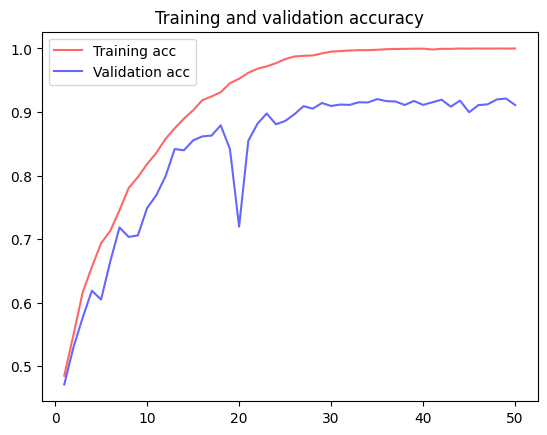

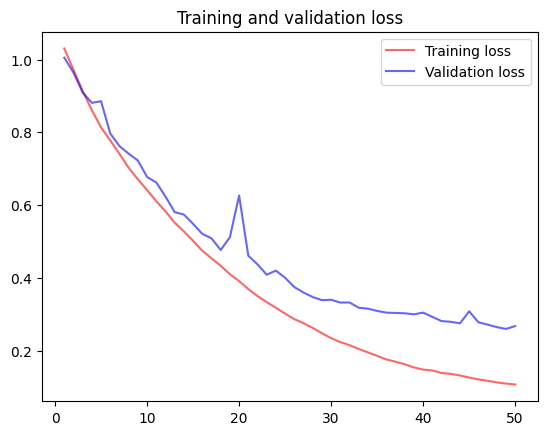

11/11 [==============================] - 12s 402ms/step


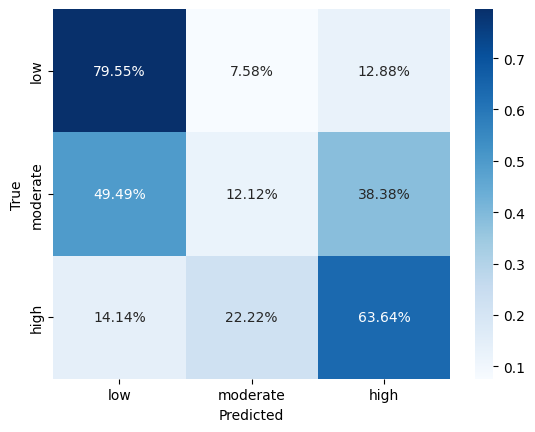

fold_1 test_acc: 0.5454545454545454
fold_1 confusion matrix: 
[[105  10  17]
 [ 49  12  38]
 [ 14  22  63]]

Metrics:
Sensitivity: 0.68
Specificity: 0.55
Precision: 0.91
FAR: 0.45
FRR: 0.32


In [ ]:
# Fit CNN+LSTM model with video data

# Initialize empty lists to store the training and validation accuracy
# train_acc_list = []
# val_acc_list = []
# train_loss_list = []
# val_loss_list = []
fold_count=0
hist = {}
seed = 7
np.random.seed(seed)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


# Use early stopping to halt the training of the model at the right time based on the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')


# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


for train_index, val_index in skf.split(X_train,Y_train):
    fold_count = fold_count + 1

    x_train, x_val = np.array(X_train)[train_index], np.array(X_train)[val_index]
    y_train, y_val = np.array(Y_train)[train_index], np.array(Y_train)[val_index]
    y_train = np_utils.to_categorical(y_train)
    y_val = np_utils.to_categorical(y_val)

    model = create_model()

    history = model.fit(
        x_train,y_train,
        epochs=50,
        batch_size=10,  # I got "ResourceExhaustedError: Graph execution error" in batch_size=60
        validation_data = (x_val,y_val),
        shuffle=True,
        callbacks=[early_stopping, checkpoint]
        )

    # history = model.fit(
    #     x_train,y_train,
    #     epochs=50,
    #     batch_size=10,
    #     validation_data = (x_val,y_val),
    #     shuffle=True
    #     )

    plot_results(history)

    # Load the best model based on the minimum validation loss
    best_model = load_model(model_checkpoint_filepath)

    test_acc, conf_mat = test_accuracy(best_model, X_test, Y_test) # this model is trained model (after fitting).

    print('fold_'+str(fold_count)+' test_acc: '+str(test_acc))
    print('fold_'+str(fold_count)+' confusion matrix: ')
    print(conf_mat)
    print()

    hist['fold'+str(fold_count)+'_history'] = history.history
    hist['fold'+str(fold_count)+'_results'] = test_acc

    # # save lists of val_acc, acc, val_loss and loss for plotting mean_of_all_folds
    # train_acc_list.append(history.history['acc'])
    # val_acc_list.append(history.history['val_acc'])

    # train_loss_list.append(history.history['loss'])
    # val_loss_list.append(history.history['val_loss'])

    get_model_metrics(conf_mat)

    # save history of each fold
    with open(history_dir + '_fold_'+str(fold_count), 'wb') as file_pi1:
        pickle.dump(hist, file_pi1)

    break
# plot_mean_of_all_folds(train_acc_list, val_acc_list, train_loss_list, val_loss_list)


In [ ]:
# Load the best model based on the minimum validation loss
best_model = load_model(model_checkpoint_filepath)

test_acc, conf_mat = test_accuracy(best_model, X_test, Y_test) # this model is trained model (after fitting).

print('fold_'+str(fold_count)+' test_acc: '+str(test_acc))
print('fold_'+str(fold_count)+' confusion matrix: ')
print(conf_mat)
print()
